<a href="https://colab.research.google.com/github/sztahodavid/humanaicourse/blob/main/emotion_recognition_images_fromscratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kép alapú érzelem felismerés konvolúciós neurális háló segítségével

A feladathoz a Kaggle adattudományi platformról használunk egy képi adatbázist, ami hét érzelmi állapotot mutat be. A kód jelentős része ugyancsak a Kaggle platformról, egy HSFIA felhasználótól származik. Az eléréshez szükség van egy felhasználó fiókra, illetve egy érvényes tokenre. A tokenben tárolt felhasználónévvel és kulccsal lehetővé válik a letöltés.

In [9]:
!pip install opendatasets

In [10]:
import opendatasets as od

od.download("https://www.kaggle.com/datasets/jonathanoheix/face-expression-recognition-dataset")


Skipping, found downloaded files in "./face-expression-recognition-dataset" (use force=True to force download)


Ezután betöltjük vizsgálat alatt használt python csomagokat.

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten,Dropout,Dense,Input,GlobalAveragePooling2D,Conv2D,BatchNormalization,Activation,MaxPooling2D
from tensorflow.keras.optimizers import Adam,SGD,RMSprop
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import model_from_json
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

Majd megadjuk az adatbázis elérési útvonalát és a képek méretét.

In [12]:
picture_size = 48
folder_path = '/content/face-expression-recognition-dataset/images/'

In [13]:
!ls
print(os.listdir(folder_path))

face-expression-recognition-dataset  sample_data
['images', 'train', 'validation']


Példaként megjelenítünk pár képet a "boldog" kategóriából a matplotlib könyvtár segítségével a tanító adathalmazból.

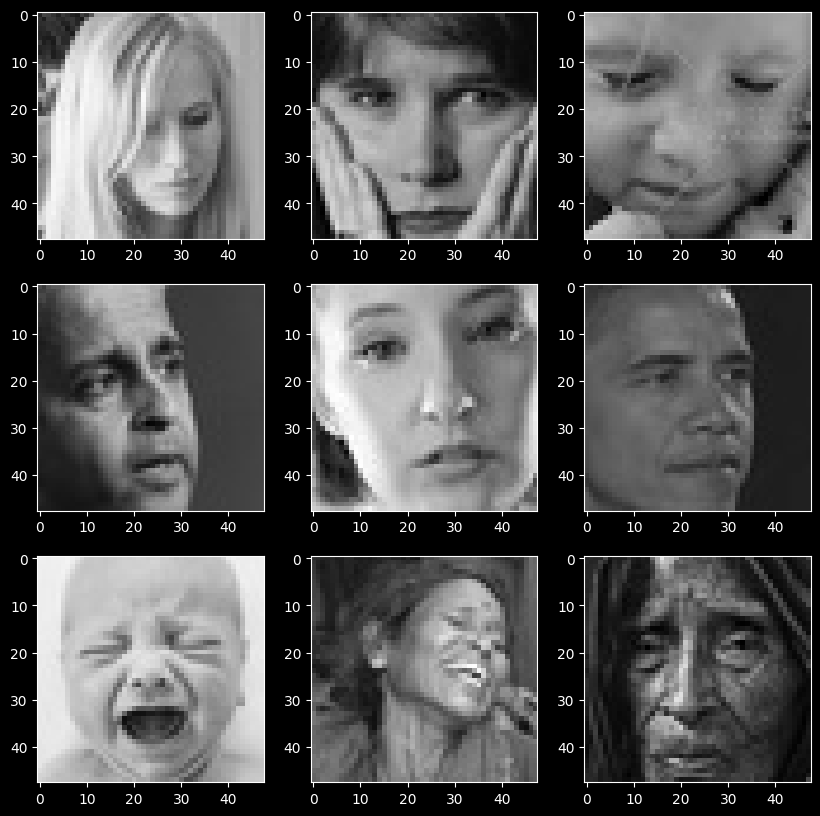

In [14]:
expression = 'sad'
plt.style.use('dark_background')
plt.figure(figsize=(10,10))

for i in range(1,10,1):
    plt.subplot(3,3,i)
    img = load_img(folder_path+"train/"+expression+"/"+ os.listdir(folder_path+"train/"+expression)[i],target_size=(picture_size,picture_size))
    plt.imshow(img)
plt.show()

A vizsgálathoz a tanító és tesztelő adathalmazból tensorokat hozunk létre az osztályozó modellhez. Ehhez megadjuk a paramétereket, mint az elérés útvonala, képek kívánt mérete, színezése, batch mérete, osztálytípusa, és hogy végezzen-e keverést rajta.

In [15]:
Batch_size = 128

datagen_train = ImageDataGenerator()
datagen_test = ImageDataGenerator()

train_set = datagen_train.flow_from_directory(folder_path + "train",
                                                 target_size = (picture_size,picture_size),
                                                 color_mode = 'grayscale',
                                                 batch_size = Batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle = True)
test_set = datagen_test.flow_from_directory(folder_path + "validation",
                                                 target_size = (picture_size,picture_size),
                                                 color_mode = 'grayscale',
                                                 batch_size = Batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle = True)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


Ezután létrehozzuk az osztályozásra a kívánt CNN modellünket. Ezt egy szekvenciális határozóval hozzuk létre, amiben felfűzzük a konvolúciós blokkokat. Egy konvolúciós blokk egy konvolúciós rétegből, egy batch normalizációból, egy relu aktivációból, egy maxpoolingból és egy dropout rétegből áll. Ebből négyet teszünk egymás után, majd jellemzővektort csinálunk belőle a flatten réteggel. Ezt két teljesen összekötött neurális háló követ, amik után szintén megjelenik a batch normalizáció, a relu aktiváció és a dropout réteg. Végül definiáljuk a learning rate optimlaizáló algoritmust és létrehozzuk a modellt.

In [16]:
#   Modell létrehozása
no_of_classes = 7

model = Sequential()

#1. CNN blokk
model.add(Conv2D(64,(3,3),padding='same',input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#2. CNN blokk
model.add(Conv2D(128,(5,5),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#3. CNN blokk
model.add(Conv2D(512,(3,3),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#4. CNN blokk
model.add(Conv2D(512,(3,3),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

#1. neurális blokk
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

#2. neurális blokk
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(no_of_classes,activation = 'softmax'))

opt = Adam()
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 48, 48, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ (None, 48, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 24, 24, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 12, 12, 512)         │         590,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 12, 12, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_8 (Activation)            │ (None, 12, 12, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 6, 6, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_9 (Activation)            │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 4,478,727 (17.08 MB)

 Trainable params: 4,474,759 (17.07 MB)

 Non-trainable params: 3,968 (15.50 KB)

Ha előállt a modell, akkor meghatározhatunk hozzá a tanulás során alkalmazandó leállási feltételeket. Ez esetben kettőt alkalmazunk: 1) korai megállást végzünk, ha a validációs költségfüggvény már nem csökken, illetve 2) csökkentjük a tanulás sebességét, ha a validációs költség már csak minimálisan csökken.

In [17]:
early_stopping = EarlyStopping(monitor='val_loss',min_delta=0,patience=10,verbose=1,restore_best_weights=True)
reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',factor=0.2,patience=3,verbose=1,min_delta=0.0001)

callbacks_list=[early_stopping,reduce_learningrate]

epochs = 50

Ezek után már lehetőség van a modell tanítására a tanító halmazon.

In [18]:
history = model.fit(train_set,
                             steps_per_epoch=train_set.n//train_set.batch_size,
                             epochs=epochs,
                             validation_data=test_set,
                             validation_steps = test_set.n//test_set.batch_size,
                             callbacks=callbacks_list)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


225/225 ━━━━━━━━━━━━━━━━━━━━ 55s 122ms/step - accuracy: 0.2578 - loss: 1.9363 - val_accuracy: 0.3878 - val_loss: 1.5960 - learning_rate: 0.0010
Epoch 2/50
  1/225 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - accuracy: 0.2969 - loss: 1.6838

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2969 - loss: 1.6838 - val_accuracy: 0.4615 - val_loss: 1.4597 - learning_rate: 0.0010
Epoch 3/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 16s 72ms/step - accuracy: 0.4276 - loss: 1.4922 - val_accuracy: 0.4378 - val_loss: 1.5875 - learning_rate: 0.0010
Epoch 4/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step - accuracy: 0.4609 - loss: 1.4028 - val_accuracy: 0.4615 - val_loss: 1.4938 - learning_rate: 0.0010
Epoch 5/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 20s 72ms/step - accuracy: 0.5060 - loss: 1.2900 - val_accuracy: 0.4800 - val_loss: 1.4243 - learning_rate: 0.0010
Epoch 6/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 104us/step - accuracy: 0.4688 - loss: 1.2934 - val_accuracy: 0.3462 - val_loss: 1.5956 - learning_rate: 0.0010
Epoch 7/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 20s 72ms/step - accuracy: 0.5485 - loss: 1.1897 - val_accuracy: 0.5514 - val_loss: 1.1767 - learning_rate: 0.0010
Epoch 8/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step - accuracy: 0.6406 - loss: 1.0967 -

A modell tanítását követően érdemes lehet kimenteni a modellt arra az esetre, ha később használni szeretnénk. Ehhez JSON formátumban kimentjük a modellt és eltáruljuk egy HDF fájlban a modell beállított súlyait. Hasonló sorrendben betölthetjük később a modellt. Azaz JSON-ből létrehozzuk a modell architektúráját, a HDF jájlból bedik betöltjük a súlyokat.

In [19]:
# Modell kiírása JSON fájlba

#model_json = model.to_json()
#with open("model_cnn.json", "w") as json_file:
#    json_file.write(model_json)

# Súlyok kiírása HDF5 fájlba

#model.save_weights("model_cnn.h5")
#print("Sikeres mentés!")

In [20]:
# Modell visszatöltése JSON fájlból

# json_file = open('model_cnn.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)

# # Súlyok betöltése a modellhez HDF5 fájlból

# loaded_model.load_weights("model_cnn.h5")
# print("Sikeres betöltés!")

FileNotFoundError: [Errno 2] No such file or directory: 'model_cnn.json'

Ezek után lehetőség van a modell teljesítményének vizsgálatára a teszhalmazon keresztül. Egyrészt lehetőség van a tévesztési mátrix létrehozására, illetve egy leíró riport elkészítésére a leggyakoribb metrikákkal, mint a pontosság, f1 érték, precizitás vagy a felidézés.

56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step


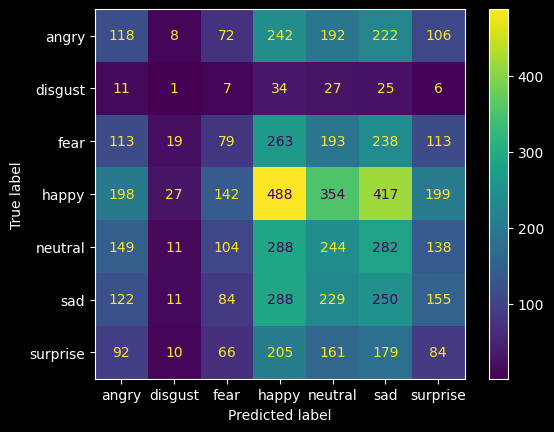

In [21]:
# Tévesztési mátrix

Y_pred = model.predict(test_set)
y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(test_set.classes, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(train_set.class_indices.keys()))
disp.plot()
plt.show()

In [23]:
# Metrika report

print('Classification Report')
target_names = list(train_set.class_indices.keys())
print(classification_report(test_set.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

       angry       0.15      0.12      0.13       960
     disgust       0.01      0.01      0.01       111
        fear       0.14      0.08      0.10      1018
       happy       0.27      0.27      0.27      1825
     neutral       0.17      0.20      0.19      1216
         sad       0.15      0.22      0.18      1139
    surprise       0.10      0.11      0.11       797

    accuracy                           0.18      7066
   macro avg       0.14      0.14      0.14      7066
weighted avg       0.18      0.18      0.18      7066

